In [1]:
# ruff: noqa
import polars as pl
from pathlib import Path
import nccdb
from llm_workflow import Experiment
from llm_classifier import LLMClassifier, file_logger

db = nccdb.get_db()

× No NCCDB drives discovered


In [ ]:
list_indication = [
    # "遺伝性ポリポーシス",
    # "遺伝性非ポリポーシス",
    "大腸癌術前検査",
    "内視鏡切除",
    "内視鏡治療前精査",
    "既知病変の検査",
    "有症状精査(下血/血便)",
    "有症状精査(下血/血便以外)",
    "他検査で異常(画像検査)",
    "他検査で異常(血液検査)",
    "原発不明がん精査",
    "便潜血精査",
    "大腸癌化療・放射線治療後評価",
    "大腸癌術後サーベイランス",
    "炎症性腸疾患サーベイランス",
    "内視鏡治療後サーベイランス",
    "無症状スクリーニング",
    "その他不明",
]

df = (
    db.cs.proc.pp.with_year()
    .filter(~pl.col("rectal_scopy").fill_null(False))
    .filter(~(pl.col("is_hcs") == True))
    .select(
        [
            "id_proc",
            "date",
            "year",
            "nendo",
            "ym",
            "j_検査目的",
            "mo_study_purpose",
            "m_special_instruct",
            "hx_surgery",
            "hx_er",
            "hx_crt",
            "hx_ibd",
            # "is_hcs",
            "e_comment",
        ]
    )
    .with_columns(
        pl.col("date").cast(pl.String),
        pl.col("hx_surgery").cast(pl.Int64).fill_nan(0),
        pl.col("hx_er").cast(pl.Int64).fill_nan(0),
        pl.col("hx_crt").cast(pl.Int64).fill_nan(0),
        pl.col("hx_ibd").cast(pl.Int64).fill_nan(0),
        pl.col("m_special_instruct")
        .replace("★★ここを右クリック★★  ★★「基準日選択」を行ってください★★", "")
        .cast(pl.String),
        # pl.col("is_hcs").cast(pl.Int64).fill_nan(0),
    )
)

experiment_dir = Path("experiment")

trainig_df = (
    pl.read_csv("data/indication_training_v6.csv")
    .select("id_proc", "indication")
    .filter(~pl.col("indication").str.contains("遺伝性"))
    .filter(pl.col("id_proc").is_in(df["id_proc"]))
    # .head(100)
)

# def generate_new_validate_df(exclude_me: pl.DataFrame, n=500):
#   return df.filter(~pl.col('id_proc').is_in(exclude_me['id_proc'])).sample(n)

# generate_new_validate_df(trainig_df, n=500).write_csv('validate_500_v2.csv')

validate_df = pl.read_csv("data/validate_500.csv").select("id_proc", "indication")


classifier = LLMClassifier(
    prompt=Path("data/prompt_v5.txt").read_text(),
    categories=list_indication,
    id_column="id_proc",
    target_column="indication",
    multiple_choice_prompt=True,
    api_base="http://127.0.0.1:1234/v1",
    model="openai/gpt-oss-20b",
    # model='google/gemma-3-4b'
)

id_column = "id_proc"
target_column = "indication"

experiment = Experiment.load(
    base_dir=experiment_dir,
    truth=trainig_df,
    id_column=id_column,
    target_column=target_column,
    categories=list_indication,
)

print("number of categories", len(list_indication))
print("number of dataframe", len(df))
print("number of truth", len(trainig_df))
print("number of validate", len(validate_df))

# else:
#     # 新規実験を作成
#     training_ids = df.sample(500, seed=42)["id_proc"].to_list()
#     # 空のtruth DataFrameを作成
#     truth = pl.DataFrame({id_column: training_ids, target_column: [None] * len(training_ids)})
#     experiment = Experiment.create(
#         base_dir=experiment_dir,
#         training_ids=training_ids,
#         id_column=id_column,
#         target_column=target_column,
#         categories=list_indication,
#         truth=truth,
#     )

number of categories 16
number of dataframe 61530
number of truth 434
number of validate 500


In [4]:
with file_logger(Path('cache/log.txt')) as logger:
    result = classifier.classify_with_cache(df, Path('cache'), groupby='ym', batch_size=10, logger=logger)

Processing groups by 'ym':   0%|          | 0/61530 [00:00<?, ?it/s]

In [14]:
result.write_csv('lm_indication.csv')

In [13]:
t = db.cs.proc.select('id_proc','indication').join(result,on='id_proc',how='left')
import plotly.express as px
px.parallel_categories(t,dimensions=['indication','lm_indication'])

In [ ]:
# result = classifier.classify(validate_df, 10, None)

2026-01-20 19:45:30.518 | INFO     | llm_workflow:classify:121 - Classification started at 2026-01-20 19:45:30.518042


Processing batches:   0%|          | 0/500 [00:00<?, ?it/s]

2026-01-20 19:45:30.543 | INFO     | llm_workflow:_process_batches:230 - Processing batch 1/50 (10 rows)
2026-01-20 19:45:30.545 | DEBUG    | llm_workflow:_get_response:137 - ----------------------------------------
2026-01-20 19:45:30.545 | DEBUG    | llm_workflow:_get_response:138 - Batch: ['Proc201412010028', 'Proc201410070003', 'Proc201210290013', 'Proc201007150011', 'Proc202011180001', 'Proc202210060041', 'Proc201410080021', 'Proc202510090078', 'Proc201604250051', 'Proc201207300016']
2026-01-20 19:45:49.867 | DEBUG    | llm_workflow:_get_response:152 - Response:
Proc201412010028,その他不明
Proc201410070003,既知病変の検査
Proc201210290013,他検査で異常(画像検査)
Proc201007150011,内視鏡切除
Proc202011180001,無症状スクリーニング
Proc202210060041,大腸癌術後サーベイランス
Proc201410080021,その他不明
Proc202510090078,内視鏡治療前精査
Proc201604250051,内視鏡治療後サーベイランス
Proc201207300016,内視鏡治療後サーベイランス
2026-01-20 19:45:49.870 | INFO     | llm_workflow:_process_batches:230 - Processing batch 2/50 (10 rows)
2026-01-20 19:45:49.871 | DEBUG    | llm_workflow:_

In [9]:
result.write_csv('validate_annotate.csv')


In [ ]:
# validate_df = df.filter(~pl.col('id_proc').is_in(truth['id_proc'])).sample(500)

In [ ]:
if True:
  # 実験を実行（Training Setに対して推論）
  run = experiment.run(
      classifier=classifier,
      df=validate_df,
      batch_size=10,
  )

  print(f"Run {run.run_id} が完了しました")

Processing batches:   0%|          | 0/434 [00:00<?, ?it/s]

Run run_026 が完了しました


shape: (26, 2)
┌─────────┬────────────────────────────┐
│ run_id  ┆ timestamp                  │
│ ---     ┆ ---                        │
│ str     ┆ datetime[μs]               │
╞═════════╪════════════════════════════╡
│ run_001 ┆ 2026-01-20 00:34:46.593108 │
│ run_002 ┆ 2026-01-20 00:34:46.593339 │
│ run_003 ┆ 2026-01-20 00:34:46.594061 │
│ run_004 ┆ 2026-01-20 00:34:46.594243 │
│ run_005 ┆ 2026-01-20 00:34:46.594422 │
│ …       ┆ …                          │
│ run_022 ┆ 2026-01-19 14:12:40.172035 │
│ run_023 ┆ 2026-01-19 21:28:34.157136 │
│ run_024 ┆ 2026-01-19 23:55:07.694681 │
│ run_025 ┆ 2026-01-20 00:17:26.972242 │
│ run_026 ┆ 2026-01-20 00:45:04.903292 │
└─────────┴────────────────────────────┘


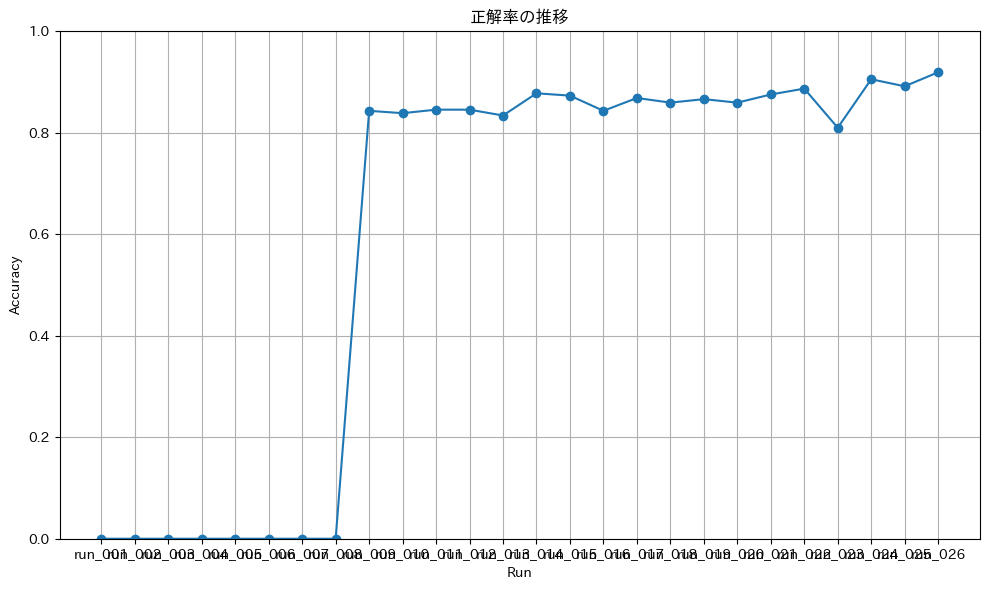


最良のrun: run_026 (accuracy=91.9%)


In [4]:
# 履歴を確認
print(experiment.history())

# 正解率の推移をグラフ表示
experiment.plot_accuracy()

# 最も良いrunを確認
best = experiment.best_run()
eval_result = best.evaluate(experiment.truth)
print(f"\n最良のrun: {best.run_id} (accuracy={eval_result.accuracy:.1%})")

正解率: 91.9% (399/434)

分類レポート:
shape: (19, 5)
┌───────────────────────┬───────────┬──────────┬──────────┬─────────┐
│ class                 ┆ precision ┆ recall   ┆ f1-score ┆ support │
│ ---                   ┆ ---       ┆ ---      ┆ ---      ┆ ---     │
│ str                   ┆ f64       ┆ f64      ┆ f64      ┆ f64     │
╞═══════════════════════╪═══════════╪══════════╪══════════╪═════════╡
│ 大腸癌術前検査        ┆ 1.0       ┆ 0.974359 ┆ 0.987013 ┆ 39.0    │
│ 内視鏡切除            ┆ 0.953846  ┆ 0.96875  ┆ 0.96124  ┆ 64.0    │
│ 内視鏡治療前精査      ┆ 0.863636  ┆ 1.0      ┆ 0.926829 ┆ 19.0    │
│ 既知病変の検査        ┆ 0.52      ┆ 0.764706 ┆ 0.619048 ┆ 17.0    │
│ 有症状精査(下血/血便) ┆ 0.888889  ┆ 0.941176 ┆ 0.914286 ┆ 17.0    │
│ …                     ┆ …         ┆ …        ┆ …        ┆ …       │
│ 無症状スクリーニング  ┆ 0.890909  ┆ 0.960784 ┆ 0.924528 ┆ 51.0    │
│ その他不明            ┆ 0.333333  ┆ 0.4      ┆ 0.363636 ┆ 5.0     │
│ micro avg             ┆ 0.919355  ┆ 0.921478 ┆ 0.920415 ┆ 433.0   │
│ macro avg             ┆ 

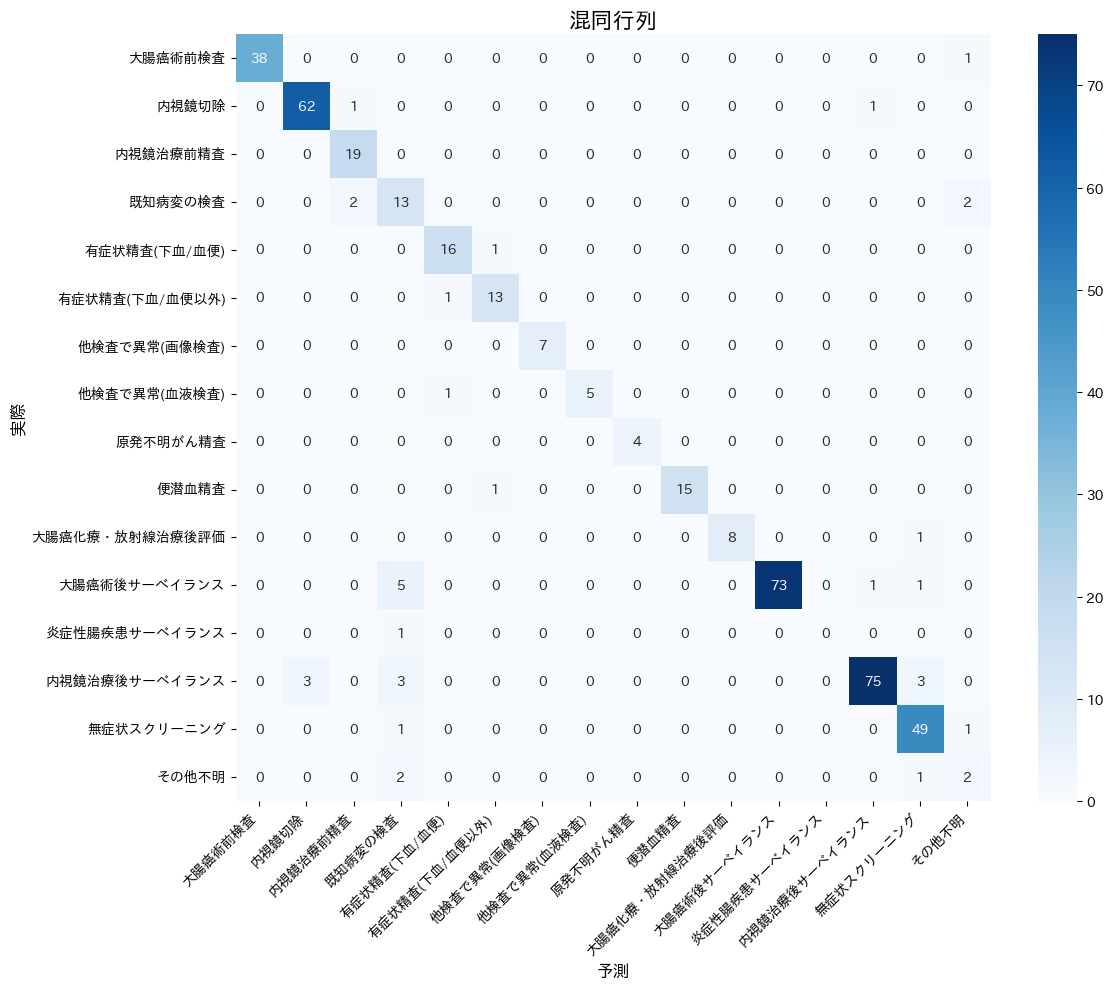


不正解サンプル数: 35
→ errors.xlsxを確認してプロンプトを改良してください


In [5]:
# 最新のrunの詳細評価を表示
if len(experiment.runs) > 0:
    latest_run = experiment.runs[-1]

    # truthと結合して評価
    eval_result = latest_run.evaluate(experiment.truth)

    eval_result.summary()

    # 混同行列を可視化
    eval_result.plot_confusion_matrix()

    # 不正解サンプルを確認
    print(f"\n不正解サンプル数: {len(eval_result.incorrect_samples)}")
    eval_result.eval_df.drop("y_true", "y_pred").with_columns(
        (pl.col("indication") == pl.col("lm_indication")).alias("correct")
    ).write_excel("eval_result.xlsx")
    eval_result.incorrect_samples.write_excel("errors.xlsx")
    print("→ errors.xlsxを確認してプロンプトを改良してください")


In [6]:
eval_result.classification_report

shape: (19, 5)
┌───────────────────────┬───────────┬──────────┬──────────┬─────────┐
│ class                 ┆ precision ┆ recall   ┆ f1-score ┆ support │
│ ---                   ┆ ---       ┆ ---      ┆ ---      ┆ ---     │
│ str                   ┆ f64       ┆ f64      ┆ f64      ┆ f64     │
╞═══════════════════════╪═══════════╪══════════╪══════════╪═════════╡
│ 大腸癌術前検査        ┆ 1.0       ┆ 0.974359 ┆ 0.987013 ┆ 39.0    │
│ 内視鏡切除            ┆ 0.953846  ┆ 0.96875  ┆ 0.96124  ┆ 64.0    │
│ 内視鏡治療前精査      ┆ 0.863636  ┆ 1.0      ┆ 0.926829 ┆ 19.0    │
│ 既知病変の検査        ┆ 0.52      ┆ 0.764706 ┆ 0.619048 ┆ 17.0    │
│ 有症状精査(下血/血便) ┆ 0.888889  ┆ 0.941176 ┆ 0.914286 ┆ 17.0    │
│ …                     ┆ …         ┆ …        ┆ …        ┆ …       │
│ 無症状スクリーニング  ┆ 0.890909  ┆ 0.960784 ┆ 0.924528 ┆ 51.0    │
│ その他不明            ┆ 0.333333  ┆ 0.4      ┆ 0.363636 ┆ 5.0     │
│ micro avg             ┆ 0.919355  ┆ 0.921478 ┆ 0.920415 ┆ 433.0   │
│ macro avg             ┆ 0.829926  ┆ 0.837714 ┆ 0.830707 ┆ 433.0   │
│ weighted avg          ┆ 0.929358  ┆ 0.921478 ┆ 0.92318  ┆ 433.0   │
└───────────────────────┴───────────┴──────────┴──────────┴─────────┘

In [7]:
fig = eval_result.plot_parallel_categories()

fig